## LIME and SHAP implementation

### Interpretability

In this notebook, we wil work on the model interpretability. First, we will implement LIME (Local interpretable model-agnostic explanations) and then explore SHAP (SHapley Additive exPlanations). Information about SHAP can be found [here](https://arxiv.org/abs/1705.07874).

### 1. Implement and Test LIME


Implementing LIME. Using the Inception V3 neural network. In addition, the focus would be on analysing the top 1 and top 2 predictions. The focus are images below. Superpixels are allowed to be used for making the task easier.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from PIL import Image
from skimage.segmentation import quickshift, mark_boundaries
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.linear_model import Ridge
from sklearn.metrics import pairwise_distances

In [2]:
# Create directories if they don't exist
os.makedirs("Assignment1_Interpretability/images", exist_ok=True)
os.makedirs("Assignment1_Interpretability/superpixels", exist_ok=True)
os.makedirs("Assignment1_Interpretability/perturbed_images", exist_ok=True)

#### Getting the images

Loading images from directory...


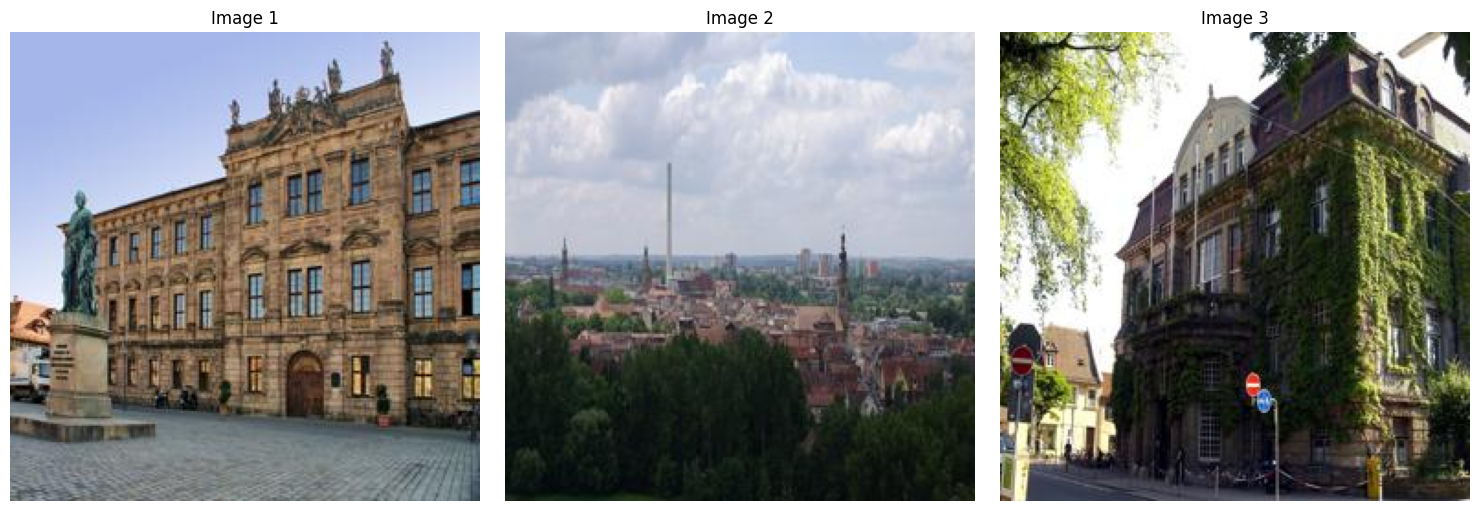

In [3]:
image_urls = [
    'https://upload.wikimedia.org/wikipedia/commons/2/2b/Schloss-Erlangen02.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/0/0c/Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/c/cc/Alte-universitaets-bibliothek_universitaet-erlangen.jpg'
]

images = []
image_dir = "Assignment1_Interpretability/images"
if not os.path.exists(image_dir) or len(os.listdir(image_dir)) == 0:
    print("Directory is empty or doesn't exist. Downloading images...")
    headers = {'User-Agent': 'Chrome'}
    for i, url in enumerate(image_urls):
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content)).convert("RGB")
            image = image.resize((256, 256))
            save_path = os.path.join(image_dir, f"image_{i}.jpg")
            image.save(save_path)
            images.append(image)
        else:
            print(f"Failed to fetch image from {url}, status code: {response.status_code}")
else:
    print("Loading images from directory...")
    for filename in sorted(os.listdir(image_dir)):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path).convert("RGB")
            images.append(image)

# Display the images
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, len(images), figure=fig)
for i, image in enumerate(images):
    ax = fig.add_subplot(gs[i])
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Image {i+1}')
plt.tight_layout()
plt.show()

#### Generating super pixels

Directory is not empty. Skipping computation.


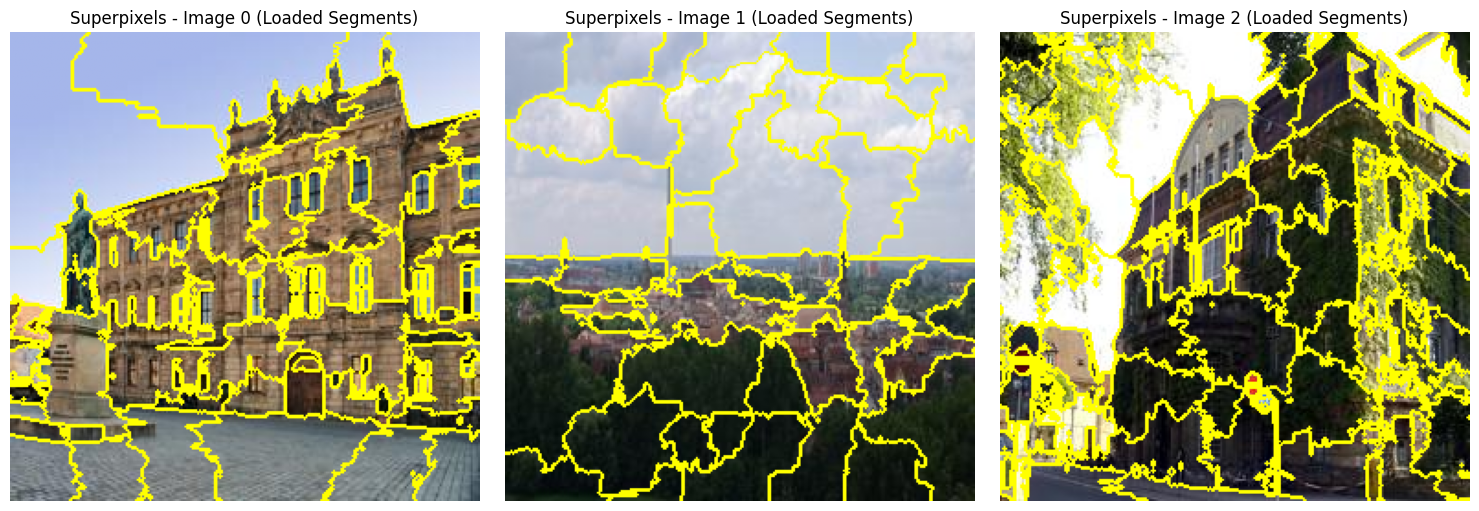

In [4]:
superpixel_dir = "Assignment1_Interpretability/superpixels"
segments_list = []

if not os.path.exists(superpixel_dir) or len(os.listdir(superpixel_dir)) == 0:
    print("Superpixel directory is empty. Computing superpixels for all images...")

    for idx, image in enumerate(images):
        image_np = np.array(image)
        segments = quickshift(image_np, ratio=1, kernel_size=5, max_dist=20)
        segments_list.append(segments)
        np.save(os.path.join(superpixel_dir, f"segments_{idx}.npy"), segments)

        # Mark boundaries
        boundary_image = mark_boundaries(image_np, segments, color=(1, 1, 0))

        plt.figure(figsize=(10, 10))
        plt.imshow(boundary_image)
        plt.axis('off')
        plt.title(f'Superpixels - Image {idx}')
        plt.show()
else:
    print("Directory is not empty. Skipping computation.")
    
    fig = plt.figure(figsize=(5 * len(images), 5))
    gs = gridspec.GridSpec(1, len(images), figure=fig)
    for idx, image in enumerate(images):
        image_np = np.array(image)

        seg_path = os.path.join(superpixel_dir, f"segments_{idx}.npy")
        if os.path.exists(seg_path):
            segments = np.load(seg_path)
            segments_list.append(segments)
            boundary_image = mark_boundaries(image_np, segments, color=(1, 1, 0))

            
            ax = fig.add_subplot(gs[idx])
            ax.imshow(boundary_image)
            ax.axis('off')
            ax.set_title(f'Superpixels - Image {idx} (Loaded Segments)')
           
    plt.tight_layout()
    plt.show()

#### Generating perturbed images

Perturbed images already exist. Skipping generation.


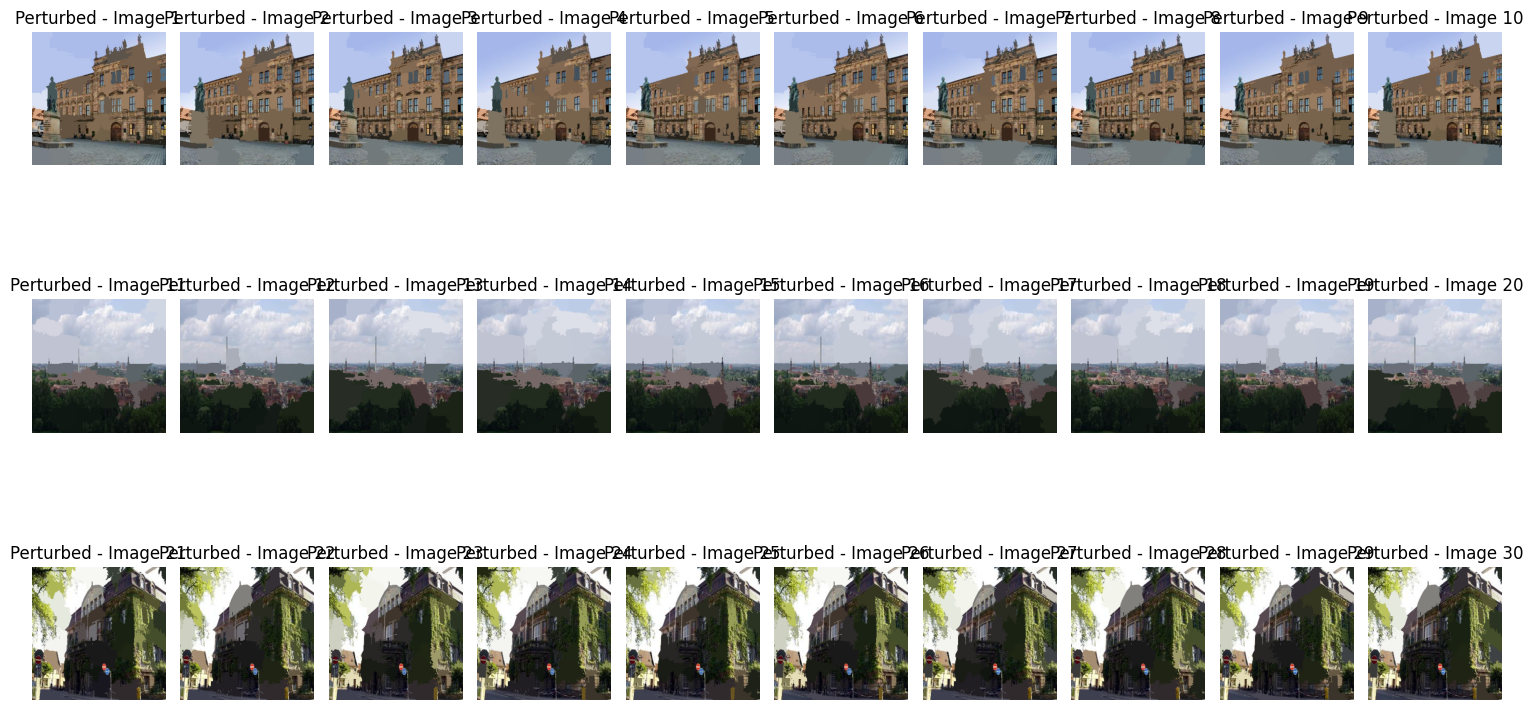

In [ ]:
def perturb_image(perturbed_dir, idx_image, image, segments, p=0.6, repeat=10):
    perturbed_images = []
    perturbed_images_masks = []
    
    for i in range(repeat):
        perturbed_image = np.array(image)
        
        n = np.max(segments) + 1
        perturbed_images_mask = np.random.binomial(1, p, size=n)
        
        for superpixel_id in range(n):
            superpixel_mask = segments == superpixel_id 
            mean_color = np.mean(perturbed_image[superpixel_mask], axis=0)
            
            if perturbed_images_mask[superpixel_id] == 0:
                perturbed_image[superpixel_mask] = mean_color
                
        # -----------------------------------------------------
        
        save_path = os.path.join(perturbed_dir, f"perturbed_image_{idx_image}_{i}.png")
        Image.fromarray(perturbed_image.astype(np.uint8)).save(save_path, format='PNG')
        
        mask_path = os.path.join(perturbed_dir, f"mask_{idx_image}_{i}.npy")
        np.save(mask_path, perturbed_images_mask)
        
        # -----------------------------------------------------
        
        perturbed_images_masks.append(perturbed_images_mask)
        perturbed_images.append(perturbed_image)
    
    return perturbed_images, perturbed_images_masks  # Return the list of masks

# -----------------------------------------------------------

perturbed_dir = "Assignment1_Interpretability/perturbed_images"
perturbed_images = []
perturbed_images_mask = []

images_dir = "Assignment1_Interpretability/images"
images = []
for filename in sorted(os.listdir(images_dir)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(images_dir, filename)
        image = Image.open(image_path).convert("RGB")
        images.append(image)

fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(15, 9))
if not os.listdir(perturbed_dir):
    print("No perturbed images found. Generating new ones...")

    for idx_image, image in enumerate(images):
        segment = segments_list[idx_image]
        x, y = perturb_image(perturbed_dir, idx_image, image, segment, p=0.6, repeat=10)
        perturbed_images.extend(x)
        perturbed_images_mask.extend(y)

    # Convert all perturbed images to PIL for consistent handling
    perturbed_images = [Image.fromarray(img.astype(np.uint8)) for img in perturbed_images]

    for idx, perturbed_image in enumerate(perturbed_images):
        row, col = divmod(idx, 10)  # Use 10 columns per row
        if row < 3:  # Ensure within bounds
            ax = axes[row, col]
            ax.imshow(perturbed_image)
            ax.axis('off')
            ax.set_title(f'Perturbed - Image {idx + 1}')
else:
    print("Perturbed images already exist. Skipping generation.")
    
    perturbed_images = []
    for filename in sorted(os.listdir(perturbed_dir)):
        if filename.endswith(".png"):
            image_path = os.path.join(perturbed_dir, filename)
            perturbed_image = Image.open(image_path)
            perturbed_images.append(perturbed_image)
    
    for idx, perturbed_image in enumerate(perturbed_images):
        row, col = divmod(idx, 10)  # Use 10 columns per row
        if row < 3:
            ax = axes[row, col]
            ax.imshow(perturbed_image)
            ax.axis('off')
            ax.set_title(f'Perturbed - Image {idx + 1}')

plt.tight_layout()
plt.show()

In [6]:
# perturbed_dir = "Assignment1_Interpretability/perturbed_images"
# perturbed_images = []
# if not os.listdir(perturbed_dir):
#     print("No perturbed images found. Generating new ones...")
    
#     for idx, segment in enumerate(segments_list):
#         image = images[idx]
#         perturbed_image = np.array(image)
#         # Randomly select superpixels to perturb
#         # binomial distribution to select which super pixels to be turned off
#         n = np.max(segment) + 1  # assuming segment labels are 0 to n-1
#         p = 0.7  # Probability of a superpixel being turned off
#         perturbed_superpixels = np.random.binomial(1, p, size=n)

#         for superpixel_id in range(n):
#             superpixel_mask = segments == superpixel_id
#             mean_color = np.mean(perturbed_image[superpixel_mask], axis=0)
            
#             # If the binomial result is 0, turn off this superpixel in the image
#             if perturbed_superpixels[superpixel_id] == 0:
#                 perturbed_image[superpixel_mask] = mean_color
                
#                 perturbed_images.append(perturbed_image)
#                 perturbed_image.save(os.path.join(perturbed_dir, f"perturbed_image_{idx}.jpg"))

        
#         fig = plt.figure(figsize=(5, 5))
#         plt.imshow(perturbed_image)
#         plt.axis('off')
#         plt.title(f'Perturbed Image - Image {idx}')
#         plt.show()
    

#### Get model predictions for each perturbation

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

model = models.inception_v3(pretrained=True, transform_input=False)
model.eval()

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

lime_predictions_grouped = []

with torch.no_grad():
    # Processing eeach original image's perturbations as a group
    num_original_images = len(images)
    for original_idx in range(num_original_images):
        # perturbations for this original image (10 per image)
        start_idx = original_idx * 10
        end_idx = (original_idx + 1) * 10
        image_group = perturbed_images[start_idx:end_idx] # 10 perturbed images for each original image
        
        predictions_group = []
        for np_image in image_group:
            input_tensor = transform(np_image).unsqueeze(0)
            output = model(input_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            predictions_group.append(probs.numpy())
        
        lime_predictions_grouped.append(predictions_group)

c:\Users\taimo\Desktop\FAU-Courses\ATDL\atdl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\taimo\Desktop\FAU-Courses\ATDL\atdl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
print(np.array(lime_predictions_grouped).shape)
# (3, 10, 1, 1000): 3 original images, 10 perturbations each, 1 batch size, 1000 classes

(3, 10, 1, 1000)


#### Calculate weights

In [9]:
from sklearn.metrics import pairwise_distances

# array of original images repeated for each perturbation
original_repeated = np.array([np.array(img).ravel() for img in images for _ in range(10)])
perturbed_flat = np.array([np.array(img).ravel() for img in perturbed_images])


dists = pairwise_distances(original_repeated, perturbed_flat, metric='cosine')
diagonal = np.diag(dists)

v = 0.25  # Kernel bandwidth
weights = np.exp(-diagonal / v**2)
weights

array([0.90721928, 0.90244554, 0.93961072, 0.87824614, 0.92546885,
       0.91600814, 0.93542295, 0.93781324, 0.89926873, 0.90515189,
       0.97115365, 0.97150591, 0.95671435, 0.9492832 , 0.97460997,
       0.97994198, 0.94576663, 0.98231958, 0.97090778, 0.95149356,
       0.87572275, 0.86930016, 0.83844086, 0.90759821, 0.91641921,
       0.88978879, 0.88519613, 0.89652452, 0.8841073 , 0.88792645])

#### Surrogate model

In [10]:
from sklearn.linear_model import LinearRegression
import torchvision.transforms as transforms

#get all the images
image_dir = "Assignment1_Interpretability/images"
images = []
for filename in sorted(os.listdir(image_dir)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert("RGB")
        images.append(image)

#get all the perturbed masks
perturbed_dir = "Assignment1_Interpretability/perturbed_images"
perturbed_masks = []
for filename in sorted(os.listdir(perturbed_dir)):
    if filename.endswith(".npy") and filename.startswith("mask_"):
        mask_path = os.path.join(perturbed_dir, filename)
        mask = np.load(mask_path)
        perturbed_masks.append(mask)

#group the perturbed masks by original image
# In our workflow, each original image has 10 perturbed images
masks_grouped = []
for i in range(len(images)):
    start_idx = i * 10
    end_idx = (i + 1) * 10
    masks_grouped.append(perturbed_masks[start_idx:end_idx])

# i could've done this in the previous step, but i wanted to keep the code clean
model = models.inception_v3(pretrained=True, transform_input=False)
model.eval()
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

all_importances = []

for img_idx, original_image in enumerate(images):
    print(f"\nProcessing image {img_idx + 1}/{len(images)}")
    
    # Get top predicted class for original image
    input_tensor = transform(original_image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
    probs = torch.nn.functional.softmax(output, dim=1)
    top_class_idx = torch.argmax(probs).item()
    
    # Prepare data for this image
    X = np.array(masks_grouped[img_idx]) # in this x value, we take the mask saved earlier with perturbed images, and get the mask with superpixels of the original image
    y = np.array([pred[0, top_class_idx] for pred in lime_predictions_grouped[img_idx]]) # predictions for the top class
    # [pred[0, top_class_idx] means that we take the first batch of predictions, and get the top class index]
    sample_weights = weights[img_idx]
    
    surrogate = LinearRegression()
    surrogate.fit(X, y, sample_weight=sample_weights)
    
    importances = surrogate.coef_
    all_importances.append(importances)
    
    print(f"Top class: {top_class_idx}")
    print(f"Superpixel importances: {importances}")


c:\Users\taimo\Desktop\FAU-Courses\ATDL\atdl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\taimo\Desktop\FAU-Courses\ATDL\atdl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Processing image 1/3
Top class: 698
Superpixel importances: [ 1.92587432e-02  1.13962028e-02  3.41825405e-03 -3.41825405e-03
  3.06518564e-03 -1.67374397e-03  2.01666209e-02  1.42607091e-02
 -2.33320510e-02  1.51647620e-02  1.16686985e-02 -6.31436230e-03
  1.67648049e-02 -3.04097625e-04  2.45102523e-02  2.59104475e-04
  3.24065668e-02  5.13933483e-03 -1.96568047e-02 -1.08863866e-02
 -4.83523721e-03 -1.63942369e-02  4.95369200e-03  1.93912896e-03
  5.71151298e-03  5.22401553e-03 -5.65308787e-03  1.25396283e-02
 -1.12643564e-02  2.07378683e-02  2.78345424e-02 -6.63689030e-03
 -3.77798684e-04  2.07378683e-02 -7.99438678e-03  3.24230496e-03
  4.32336849e-03  2.07378683e-02  8.77669862e-03 -1.57978004e-03
  1.63942369e-02  4.34363136e-03  9.17476018e-03 -6.28276032e-03
 -3.24230496e-03 -7.37010589e-05 -1.87600267e-02 -2.85822576e-03
  4.82151518e-04 -1.30200855e-02 -1.01555793e-02 -1.21445695e-02
  2.30216729e-02  1.18404719e-02 -1.17667708e-02  1.51647620e-02
 -2.29810949e-02  2.04769991e

#### Explain and visualise

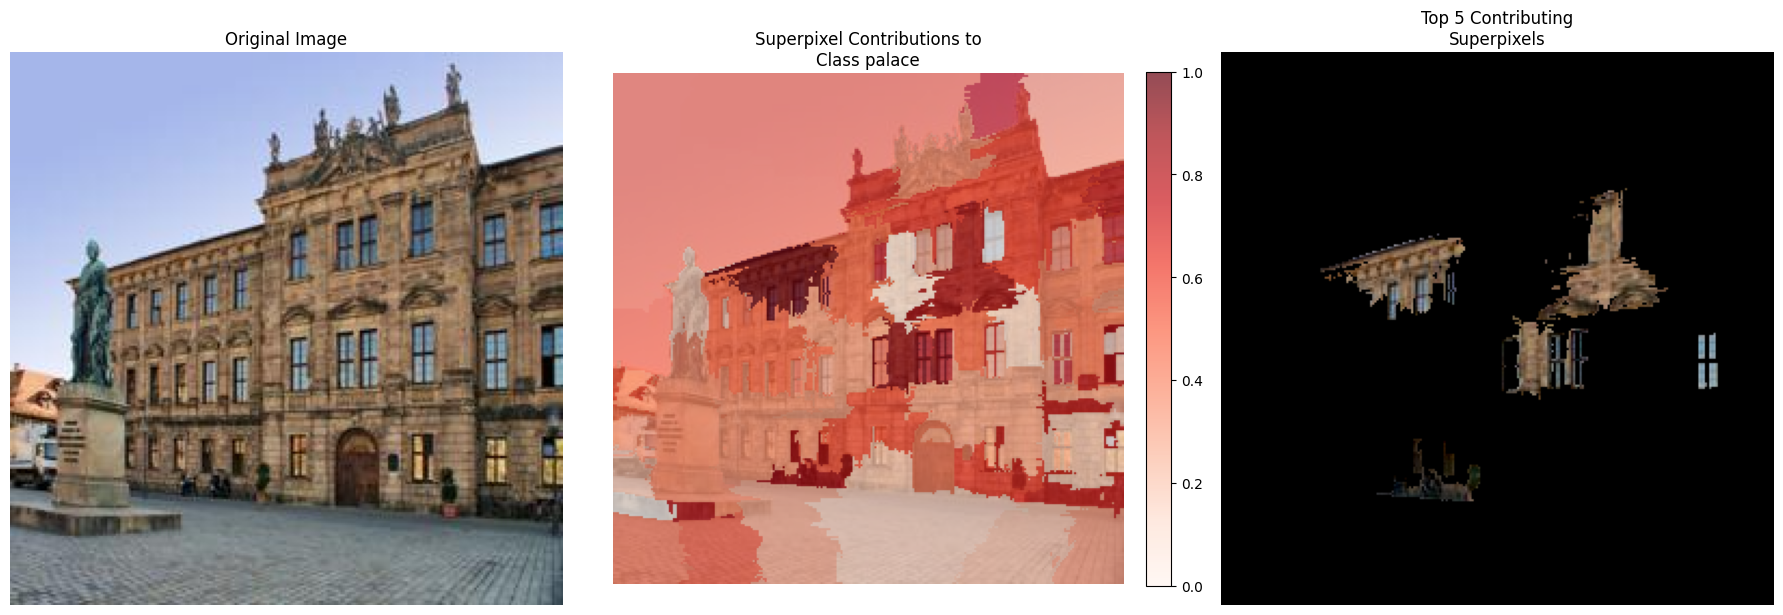

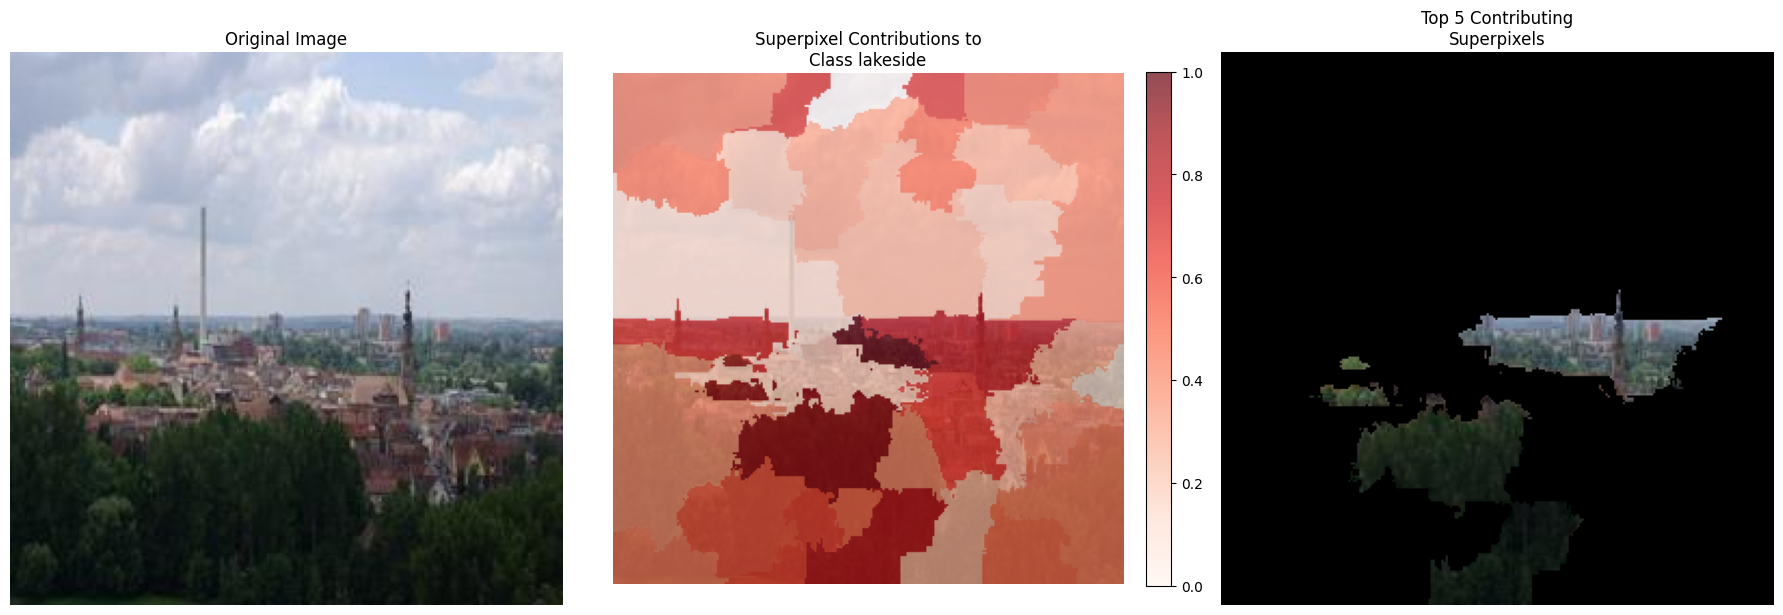

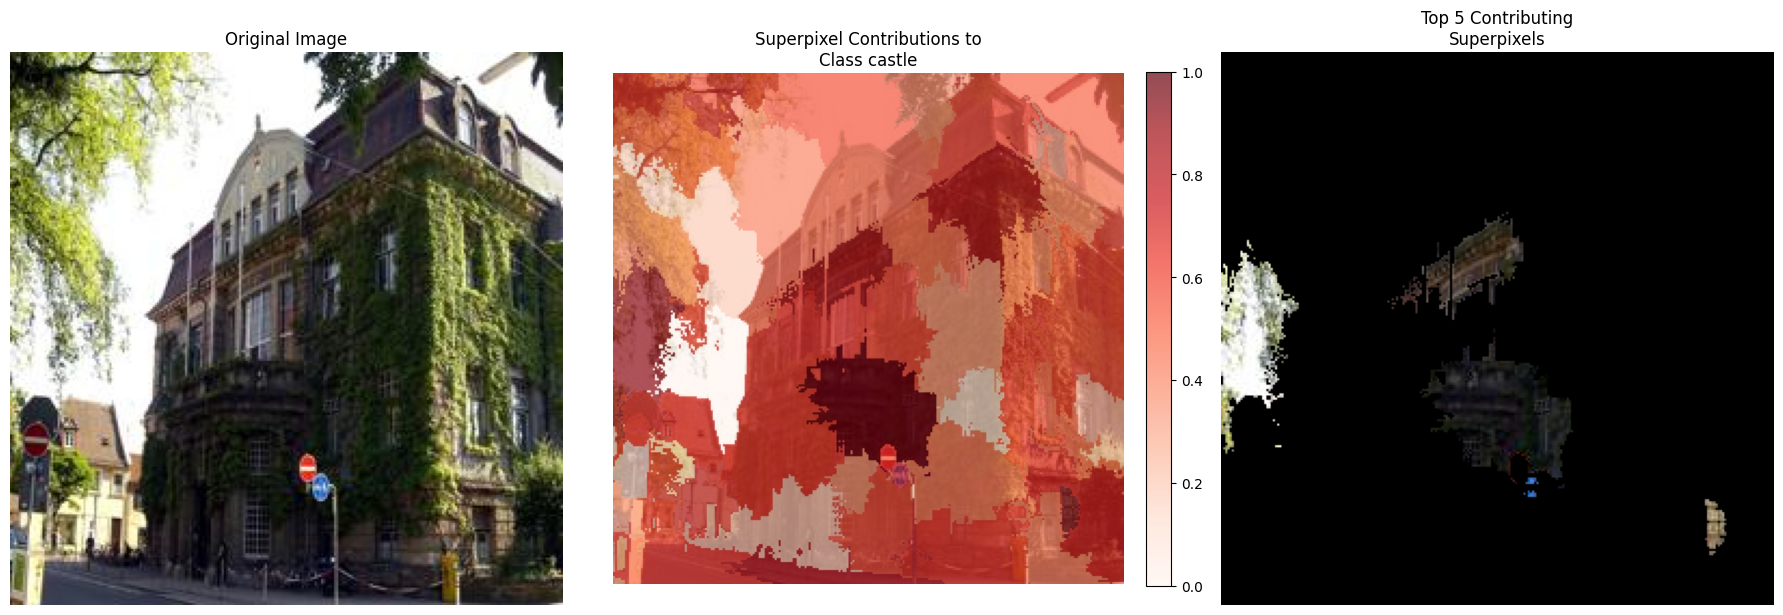

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import numpy as np
import json
import urllib.request

def explain_and_visualize(image, segments, importances, top_class_name, top_n=5):
    # Convert PIL Image to NumPy array if necessary
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original Image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Explanation heatmap
    explanation = np.zeros_like(segments, dtype=np.float32)
    for sp_idx in range(len(importances)):
        explanation[segments == sp_idx] = importances[sp_idx]
    
    # Normalize for visualization
    explanation = (explanation - explanation.min()) / (explanation.max() - explanation.min())
    
    # Explanation overlay
    axes[1].imshow(image)
    im = axes[1].imshow(explanation, alpha=0.7, cmap='Reds')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    axes[1].set_title(f"Superpixel Contributions to\n{top_class_name}")
    axes[1].axis('off')
    
    # Top contributing superpixels
    sorted_indices = np.argsort(importances)[::-1]
    top_combined_mask = np.zeros_like(segments, dtype=bool)
    
    for idx in sorted_indices[:top_n]:
        top_combined_mask |= (segments == idx)
    
    # Ensure image is a NumPy array for boolean indexing
    masked_image = image.copy()
    masked_image[~top_combined_mask] = 0  # Apply mask to all channels
    axes[2].imshow(masked_image)
    # axes[2].imshow(image)
    # axes[2].imshow(top_combined_mask, alpha=0.5)
    axes[2].set_title(f"Top {top_n} Contributing\nSuperpixels")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
# --------------------------Get the class names-----------------------------------

URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
urllib.request.urlretrieve(URL, "imagenet_class_index.json")

with open("imagenet_class_index.json", "r") as f:
    class_idx = json.load(f)

# ---------------------------Visualize the explanations-----------------------------------

for img_idx in range(len(images)):
    
    image = images[img_idx]
    segments = segments_list[img_idx]
    importances = all_importances[img_idx]
    
    top_class_idx = np.argmax(lime_predictions_grouped[img_idx][0][0])
    wnid, human_name = class_idx[str(top_class_idx)]
    top_class_name = f"Class {human_name}"
    
    explain_and_visualize(image, segments, importances, top_class_name, top_n=5)

### 2. Test SHAP

For the same images, SHAP algorithm will be used to provide visual explanations. In this case, we are not going to implement SHAP from scratch. Instead, we will be using existing Python library such as [SHAP](https://shap.readthedocs.io/en/latest/image_examples.html). ResNet 50 is a good reference for running the tests, which we will use. Inception V3 can also be used. For this task, [TensorFlow](https://www.tensorflow.org) can be used as well but I will try to use pytorch.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

![](https://shap.readthedocs.io/en/latest/_images/example_notebooks_image_examples_image_classification_Explain_ResNet50_using_the_Partition_explainer_10_0.png)

In [ ]:
import requests
from PIL import Image
import os
from io import BytesIO

images = []
image_dir = "Assignment1_Interpretability/images"
image_urls = [
    'https://upload.wikimedia.org/wikipedia/commons/2/2b/Schloss-Erlangen02.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/0/0c/Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/c/cc/Alte-universitaets-bibliothek_universitaet-erlangen.jpg'
]


if not os.path.exists(image_dir) or len(os.listdir(image_dir)) == 0:
    print("Directory is empty or doesn't exist. Downloading images...")
    headers = {'User-Agent': 'Chrome'}
    for i, url in enumerate(image_urls):
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content)).convert("RGB")
            image = image.resize((256, 256))
            save_path = os.path.join(image_dir, f"image_{i}.jpg")
            image.save(save_path)
            images.append(image)
        else:
            print(f"Failed to fetch image from {url}, status code: {response.status_code}")
else:
    print("Loading images from directory...")
    for filename in sorted(os.listdir(image_dir)):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path).convert("RGB")
            images.append(image)
            
def model_predict(img_np):
    t = torch.from_numpy(img_np).permute(0, 3, 1, 2).float() / 255.0 # convert to tensor and normalize
    mean = torch.tensor([0.485,0.456,0.406]).view(1,3,1,1) # mean for normalization
    std  = torch.tensor([0.229,0.224,0.225]).view(1,3,1,1) # std for normalization
    t = (t - mean) / std # normalize
    with torch.no_grad():
        logits = model(t)
    return logits.numpy()

Loading images from directory...


Processing image 1/3...


PartitionExplainer explainer: 2it [00:37, 37.61s/it]               


shape: (1, 256, 256, 3, 4)
min, max: -7.463180145350634e-05 0.00011630600647549727
nan count: 0


<Figure size 1000x1000 with 0 Axes>

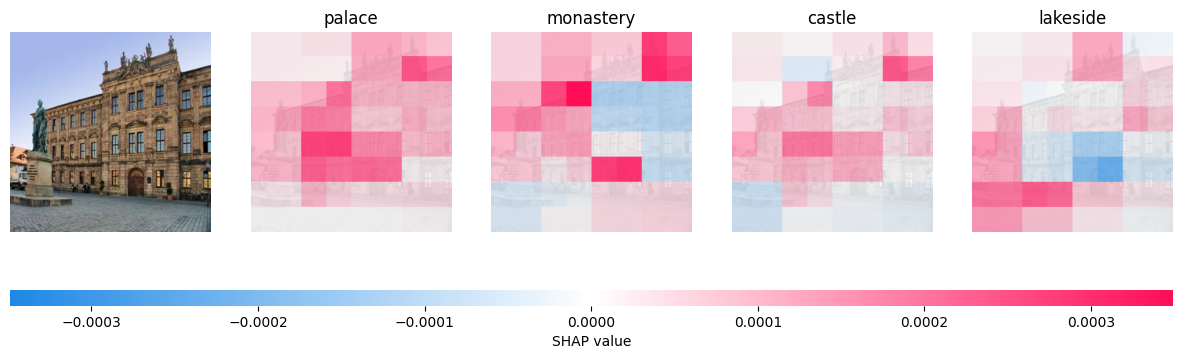

Processing image 2/3...


PartitionExplainer explainer: 2it [00:34, 34.18s/it]               


shape: (1, 256, 256, 3, 4)
min, max: -2.3657665527328692e-05 0.00014699692129246009
nan count: 0


<Figure size 1000x1000 with 0 Axes>

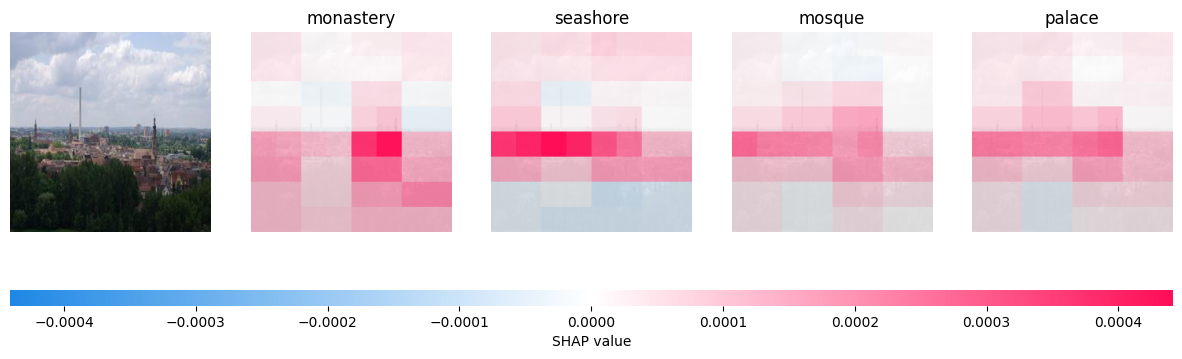

Processing image 3/3...


PartitionExplainer explainer: 2it [00:37, 37.60s/it]               


shape: (1, 256, 256, 3, 4)
min, max: -3.435912443213359e-05 0.00011314561917667258
nan count: 0


<Figure size 1000x1000 with 0 Axes>

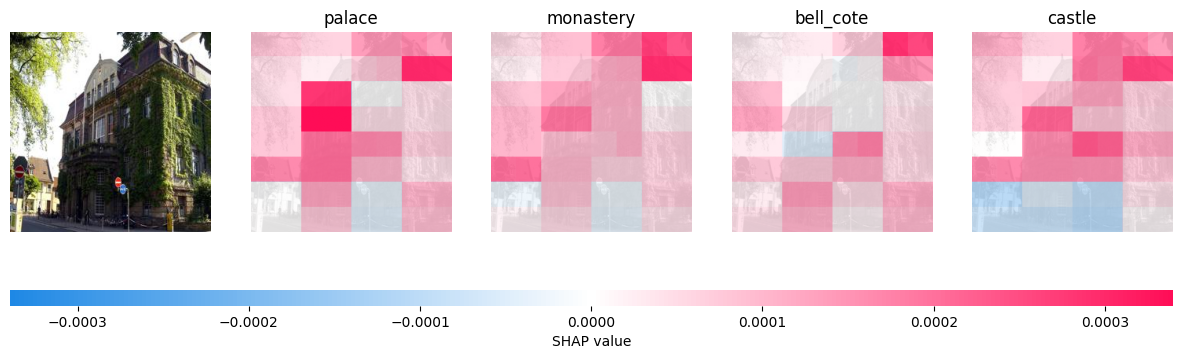

Processing complete!


In [32]:
import torch
import torchvision
from torchvision import transforms
import shap
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import json
import urllib.request

RESOLUTION = 256
            
# ------------------------------------------------------------

model = torchvision.models.resnet50(weights='DEFAULT').eval()

masker = shap.maskers.Image("inpaint_telea", (RESOLUTION, RESOLUTION, 3))
explainer = shap.Explainer(model_predict, masker)

image_nps = [np.array(img.resize((RESOLUTION, RESOLUTION))) for img in images]

# ------------------------------------------------------------

URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
urllib.request.urlretrieve(URL, "imagenet_class_index.json")

with open("imagenet_class_index.json", "r") as f:
    class_idx = json.load(f)

# ------------------------------------------------------------

for idx, img in enumerate(image_nps):
    print(f"Processing image {idx+1}/{len(image_nps)}...")
    
    try:
        gc.collect()
        
        inp = img[None, ...]
        logits = model_predict(inp)
        top_class = np.argmax(logits, axis=1)[0]
        
        shap_values = explainer(
            inp, 
            max_evals=300,
            batch_size=10,
            outputs=shap.Explanation.argsort.flip[:4] 
        )
        
        print("shape:", shap_values.values.shape)
        print("min, max:", shap_values.values.min(), shap_values.values.max())
        print("nan count:", np.isnan(shap_values.values).sum())

        plt.figure(figsize=(10, 10))
        # top 4 class indices in descending order
        sorted_indices = np.argsort(logits[0])
        top4_classes = sorted_indices[-4:][::-1]
        # human-readable names for the top 4 classes
        top4_class_name = [class_idx[str(cls)] for cls in top4_classes]
        top4_class_names = [hn for (wnid, hn) in top4_class_name]
        
        # Plot SHAP values with labels
        shap.image_plot(
            shap_values,
            inp.astype(np.float32) / 255.0,
            show=False,
            labels=[top4_class_names]
        )
        
        # plt.figure(figsize=(10, 10))
        # shap.image_plot(
        #     shap_values,
        #     inp.astype(np.float32) / 255.0,         
        #     show=False
        # )
        
        shap_image_dir = "Assignment1_Interpretability/shap_images"
        if not os.path.exists(shap_image_dir):
            os.makedirs(shap_image_dir)
        plt.savefig(os.path.join(shap_image_dir, f"shap_explanation_image_{idx+1}.png"), bbox_inches='tight')
        plt.show()
        
        # Free memory
        del shap_values
        gc.collect()
        
    except Exception as e:
        print(f"Error processing image {idx+1}: {e}")
        import traceback
        traceback.print_exc()

print("Processing complete!")